In [64]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import joblib

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, TimeDistributed, Flatten, RepeatVector, InputLayer, Reshape, Dropout
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from scipy.stats import boxcox

import matplotlib.pyplot as plt

In [3]:
class Evaluation:
    def __init__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true

    def nrmse(self):
        mse = mean_squared_error(self.y_true, self.y_pred)
        rmse = np.sqrt(mse)
        return rmse / (self.y_true.max() - self.y_true.min())

    def mase(self):
        n = len(self.y_true)
        d = np.abs(np.diff(self.y_true)).sum() / (n - 1)
        errors = np.abs(self.y_true - self.y_pred)
        return errors.mean() / d

    def mape(self):
        return np.mean(np.abs((self.y_true - self.y_pred) / self.y_true)) * 100




In [40]:
class GeneratePlots:
    def __init__(self, processor):
        self.processor = processor
        
    def plot_model_evaluation(self, y_test, y_pred):
        if y_test.ndim == 4:
            M = y_test.shape[2]
            SNR_values = y_test.shape[3]  # Number of SNR values
        else:
            M = y_test.shape[2]  # Number of users
            SNR_values = 1  # No SNR dimension
        # Ensure y_test and y_pred are reshaped to (num_samples, time steps, users, features)
        # Assuming the last dimension has the real and imaginary parts
        # Here, reshape is needed only if y_test and y_pred don't already match this form
        K = y_test.shape[0]
        time_steps = np.arange(13986, 13986+K)

        # Get the max amplitude
        max_amplitude_test = np.max(y_test[:, :, 0].reshape(-1)**2)
        max_amplitude_pred = np.max(y_pred[:, :, 0].reshape(-1)**2)

        for user in range(M):
            plt.figure(figsize=(20, 10))

            # Extract the amplitude of the received signals for each user
            amplitude_test = y_test[:, :, user].reshape(-1)
            amplitude_pred = y_pred[:, :, user].reshape(-1)

            # Calculate the amplitude of the received signals for each user
            amplitude_test = (amplitude_test**2)
            amplitude_pred = (amplitude_pred**2)

            # Normalize the amplitudes
            normalized_amplitude_test = amplitude_test / max_amplitude_test
            normalized_amplitude_pred = amplitude_pred / max_amplitude_pred
            # Plot the normalized received power for each user and SNR
            plt.plot(time_steps, normalized_amplitude_test, label=f'User {user + 1} Test')
            plt.plot(time_steps, normalized_amplitude_pred, '--', label=f'User {user + 1} Pred')

            # Label the axes and create a title and legend
            plt.xlabel('Time Step')
            plt.ylabel(f'Cascaded channel at user {user + 1}')
            plt.legend()
            plt.grid(True)
            plt.show()

    def plot_training_history(self, history):
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend(["train", "val"], loc="best")
        plt.grid(True)
        plt.show()
    
    def plot_training_accuracy_history(self, history):
        plt.figure(figsize=(12, 6))
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy Over Epochs')
        plt.legend(["train", "val"], loc="best")
        plt.grid(True)
        plt.show()

    def plot_model_metrics(self, y_test, y_pred):

        y_pred_flat = y_pred.reshape(-1, 2)  # Flatten to 2D
        y_test_flat = y_test.reshape(-1, 2)  # Flatten to 2D
        evaluation = Evaluation(y_test_flat, y_pred_flat)
        # Calculate metrics
        nrmse_val = evaluation.nrmse()
        mase_val = evaluation.mase()
        mape_val = evaluation.mape()
        r2_val = r2_score(y_test_flat, y_pred_flat)

        print(f"NRMSE: {nrmse_val}")
        print(f"MASE: {mase_val}")
        print(f"MAPE: {mape_val}")
        print(f"R2 Score: {r2_val}")

        # Metrics for plotting
        metrics = ['NRMSE', 'MASE', 'MAPE', 'R2 Score']
        values = [nrmse_val, mase_val, mape_val, r2_val]

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.bar(metrics, values, color='skyblue')
        plt.xlabel('Metrics')
        plt.ylabel('Values')
        plt.title('Model Evaluation Metrics')
        plt.ylim([0, max(values) + 0.05 * max(values)])  # Adjust y-axis limit
        # Annotate each bar with the value
        for i, v in enumerate(values):
            plt.text(i, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.show()


In [69]:
class CNNLSTMModel:
    def __init__(self, processor):
        self.processor = processor
        self.model = Sequential()
        self.build_model()

    def build_model(self):
        t_i = self.processor.t_i
        M = self.processor.M
        N_t = self.processor.N_t
        N_r = self.processor.N_r
        t_o = self.processor.t_o

        self.model.add(InputLayer(input_shape=(t_i, M, 2*N_t*N_r)))
        self.model.add(Conv2D(64, kernel_size=(3, 1), padding='same', activation='relu'))
        #self.model.add(Conv2D(64, kernel_size=(3, 1), padding='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Flatten())
        self.model.add(RepeatVector(t_o))
        self.model.add(LSTM(16, activation='tanh', return_sequences=True))
        #self.model.add(LSTM(16, activation='tanh', return_sequences=True))
        self.model.add(TimeDistributed(Dense(2)))
        #self.model.add(Reshape((t_o, M, 2)))
        self.model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        self.model.summary()

    def train_model(self, X_train, y_train, X_val_scaled, y_val_scaled, batch_size = 64, epochs=1000):
        return self.model.fit(X_train, y_train, validation_data=(X_val_scaled, y_val_scaled), epochs=epochs, batch_size=batch_size)
    
    def predict_model(self, X_test):
        return self.model.predict(X_test)
    
    def evaluate_model(self, x_test, y_test):
        test_loss, test_acc = self.model.evaluate(x_test, y_test)
        return test_loss, test_acc

In [70]:
class DatasetProcessor:
    def __init__(self, file_path, t_i, t_o, N_t, N_r):
        self.file_path = file_path
        self.t_i = t_i  # Number of input time steps
        self.t_o = t_o  # Number of output time steps
        self.N_t = N_t  # Number of transmit antennas
        self.N_r = N_r  # Number of receive antennas
        self.M = None
        self.K = None
        self.SNR = None

    def load_data(self):
        # Load the .mat dataset
        data = scipy.io.loadmat(self.file_path)
        Y = data["Y"]
        G = data["G"]
        if Y.ndim == 4:
            Y = np.transpose(Y, (2, 1, 3, 0))
            self.SNR = Y.shape[2]
        else:
            Y = np.transpose(Y, (2, 1, 0))
        if G.ndim == 4:
            G = np.transpose(G, (2, 1, 3, 0))
        else:
            G = np.transpose(G, (2, 1, 0))
        return Y, G
    
    def preprocess_data(self, Y, G):
        self.K = Y.shape[0]  # Number of timesteps
        self.M = Y.shape[1]  # Number of users
        Sample = self.K - self.t_i - self.t_o + 1
        print(Sample)

        amplitude_G = G[:,:,0]

        # Create sequences for input and output
        X = np.array([Y[i:i+self.t_i] for i in range(Sample)])
        y = np.array([amplitude_G[i + self.t_i:i + self.t_i + self.t_o] for i in range(Sample)])
        return X, y
    
    def sequential_split_data(self, X, y, test_size=0.3, val_size=0.1):
        # Calculate split indices
        num_samples = X.shape[0]
        test_split_index = int(num_samples * (1 - test_size))
        train_val_split_index = int(test_split_index * (1 - val_size))

        # Perform sequential splits
        X_train_full, y_train_full = X[:test_split_index], y[:test_split_index]
        X_train, y_train = X_train_full[:train_val_split_index], y_train_full[:train_val_split_index]
        X_val, y_val = X_train_full[train_val_split_index:], y_train_full[train_val_split_index:]
        X_test, y_test = X[test_split_index:], y[test_split_index:]

        return X_train, y_train, X_val, y_val, X_test, y_test

    def normalize_data(self, X_train, y_train, X_val, y_val, X_test, y_test):
        # Normalize data
        scaler_X = MinMaxScaler()
        scaler_y = MinMaxScaler()

        X_train_scaled = scaler_X.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_val_scaled = scaler_X.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
        X_test_scaled = scaler_X.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

        y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
        y_val_scaled = scaler_y.transform(y_val.reshape(-1, y_val.shape[-1])).reshape(y_val.shape)
        y_test_scaled = scaler_y.transform(y_test.reshape(-1, y_test.shape[-1])).reshape(y_test.shape)

        # Save the scalers
        joblib.dump(scaler_X, 'scaler_X.pkl')
        joblib.dump(scaler_y, 'scaler_y.pkl')

        return X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled


In [41]:
def grid_search_Nfilters(processor, X_train, y_train, X_test, y_test, Nfilter1_values, Nfilter2_values):
        results = []
        
        for Nfilter1 in Nfilter1_values:
            for Nfilter2 in Nfilter2_values:
                
                # Initialize and build the model
                model = CNNLSTMModel(processor, Nfilter1, Nfilter2)
                
                # Train the model
                model.train_model(X_train, y_train)
                
                # Evaluate the model
                test_loss, test_acc = model.evaluate_model(X_test, y_test)
                
                # Store the results
                results.append({
                    'Nfilter1': Nfilter1,
                    'Nfilter2': Nfilter2,
                    'test_loss': test_loss,
                    'test_acc': test_acc
                })
                
                print(f"Nfilter1={Nfilter1}, Nfilter2={Nfilter2}: Test Loss = {test_loss}, Test Accuracy = {test_acc}")
        
        return results

# Nfilter1=64, Nfilter2=64: Test Loss = 0.012378140352666378, Test Accuracy = 0.7205955982208252
# Nfilter1=4, Nfilter2=4: Test Loss = 0.013206719420850277, Test Accuracy = 0.7143393158912659
# Nfilter1=4, Nfilter2=8: Test Loss = 0.01393490843474865, Test Accuracy = 0.7012012004852295
# Nfilter1=4, Nfilter2=16: Test Loss = 0.013972993940114975, Test Accuracy = 0.6999499201774597
# Nfilter1=4, Nfilter2=64: Test Loss = 0.01888369955122471, Test Accuracy = 0.6763013005256653
# Nfilter1=8, Nfilter2=4: Test Loss = 0.012817522510886192, Test Accuracy = 0.7173423171043396
# Nfilter1=8, Nfilter2=8: Test Loss = 0.013387846760451794, Test Accuracy = 0.7117117047309875
# Nfilter1=8, Nfilter2=16: Test Loss = 0.014078735373914242, Test Accuracy = 0.6958208084106445
# Nfilter1=8, Nfilter2=64: Test Loss = 0.016480514779686928, Test Accuracy = 0.6831831932067871
# Nfilter1=16, Nfilter2=4: Test Loss = 0.012622952461242676, Test Accuracy = 0.7204704880714417
# Nfilter1=16, Nfilter2=8: Test Loss = 0.013172678649425507, Test Accuracy = 0.7109609842300415
# Nfilter1=16, Nfilter2=16: Test Loss = 0.014708010479807854, Test Accuracy = 0.6965715885162354
# Nfilter1=16, Nfilter2=64: Test Loss = 0.018291575834155083, Test Accuracy = 0.6771771907806396
# Nfilter1=64, Nfilter2=4: Test Loss = 0.012815110385417938, Test Accuracy = 0.7150900959968567
# Nfilter1=64, Nfilter2=8: Test Loss = 0.015085449442267418, Test Accuracy = 0.7022022008895874
# Nfilter1=64, Nfilter2=16: Test Loss = 0.01513038668781519, Test Accuracy = 0.6931931972503662
# Nfilter1=64, Nfilter2=64: Test Loss = 0.012378140352666378, Test Accuracy = 0.7205955982208252


In [30]:
def batch_size_grid_search(processor, X_train, y_train, X_val_scaled, y_val_scaled, X_test, y_test, batch_size_values):
    results = []

    for batch_size in batch_size_values:
        # Initialize and build the model
        model = CNNLSTMModel(processor)
        
        # Train the model
        model.train_model(X_train, y_train, X_val_scaled, y_val_scaled, batch_size)
        
        # Evaluate the model
        test_loss, test_acc = model.evaluate_model(X_test, y_test)
        
        # Store the results
        results.append({
            'batch_size': batch_size,
            'test_loss': test_loss,
            'test_acc': test_acc
        })
        
        print(f"batch_size={batch_size}: Test Loss = {test_loss}, Test Accuracy = {test_acc}")
        
    return results

# batch_size=4: Test Loss = 3.1704727007308975e-05, Test Accuracy = 0.5387887954711914
# batch_size=16: Test Loss = 2.9865463147871196e-05, Test Accuracy = 0.5387887954711914
# batch_size=32: Test Loss = 3.1243307603290305e-05, Test Accuracy = 0.5415415167808533
# batch_size=64: Test Loss = 1.3201074580138084e-05, Test Accuracy = 0.532282292842865

19980
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_51 (Conv2D)          (None, 20, 2, 64)         448       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 10, 1, 64)         0         
 ng2D)                                                           
                                                                 
 flatten_26 (Flatten)        (None, 640)               0         
                                                                 
 repeat_vector_26 (RepeatVe  (None, 1, 640)            0         
 ctor)                                                           
                                                                 
 lstm_52 (LSTM)              (None, 1, 16)             42048     
                                                                 
 time_distributed_26 (TimeD  (None, 1, 2)      

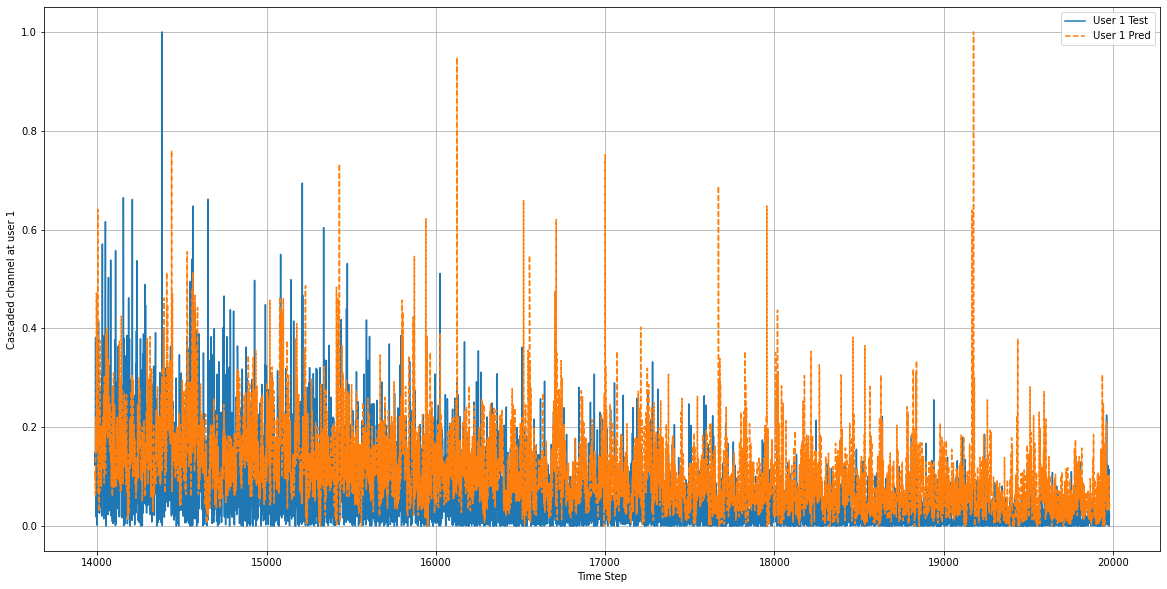

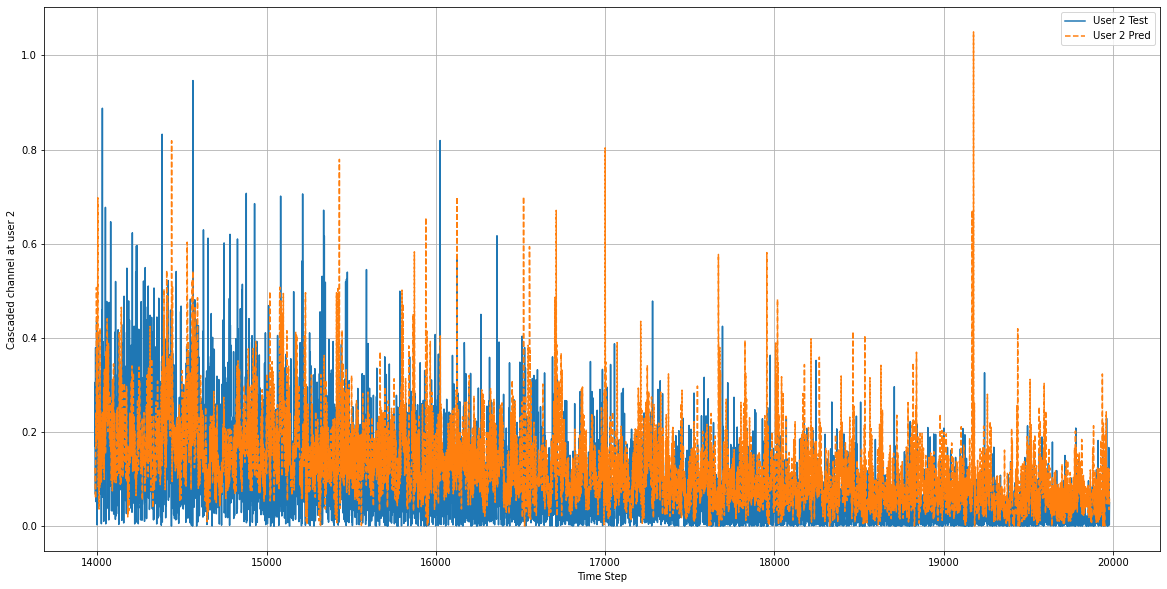

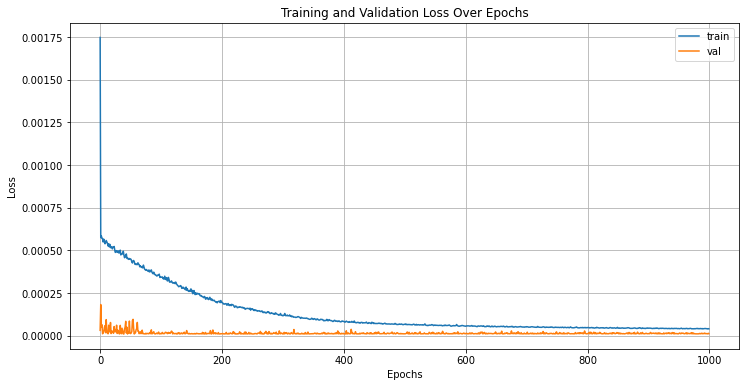

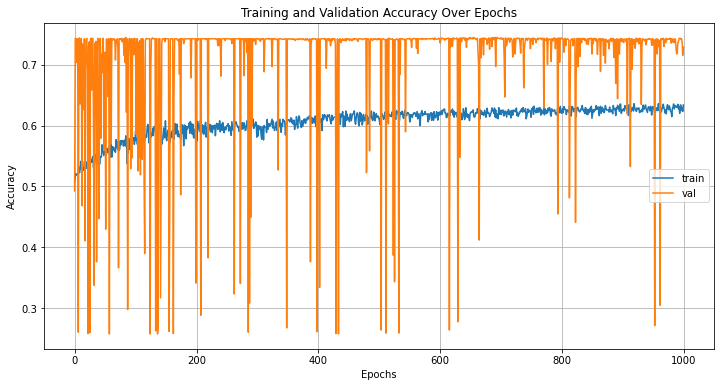

NRMSE: 0.12803016490634458
MASE: 5.877761714721125
MAPE: 63.96921474411933
R2 Score: -0.6832576816852107


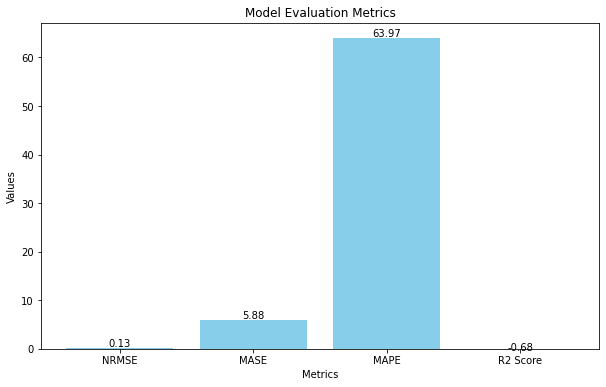

In [71]:
def main():
    processor = DatasetProcessor("dataset.mat", 20, 1, 1, 1)
    Y, G = processor.load_data()
    
    if Y.ndim == 4:
        for snr_index in range(processor.SNR):
            print(f"Processing SNR index: {snr_index + 1}/{processor.SNR}")
            
            Y_snr = Y[:, :, snr_index, :]
            G_snr = G[:, :, snr_index, :]
            
            X, y = processor.preprocess_data(Y_snr, G_snr)
            X_train, X_test, X_val, y_val, y_train, y_test = processor.sequential_split_data(X, y)
            X_train_reshaped, y_train_reshaped = processor.reshape_for_cnn(X_train_scaled, y_train_scaled)
        
            model = CNNLSTMModel(processor)
            history = model.train_model(X_train_reshaped, y_train_reshaped)
            y_pred = model.predict_model(X_test)
            plotter = GeneratePlots(processor)
            plotter.plot_model_evaluation(y_test, y_pred)
            plotter.plot_training_history(history)
    else:

        ## Preprocessing
        X, y = processor.preprocess_data(Y, G)
        # Split data sequentially
        X_train, y_train, X_val, y_val, X_test, y_test = processor.sequential_split_data(X, y)

        # Normalize data
        X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled = processor.normalize_data(X_train, y_train, X_val, y_val, X_test, y_test)
        #print(X_train_scaled.shape, y_train_scaled.shape, X_val_scaled.shape, y_val_scaled.shape, X_test_scaled.shape, y_test_scaled.shape)
        # # Define Nfilter values for each Conv2D layer
        # Nfilter1_values = [4, 8, 16, 64]
        # Nfilter2_values = [4, 8, 16, 64]

        # # Perform grid search
        # results = grid_search_Nfilters(processor, X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, Nfilter1_values, Nfilter2_values)

        # # Display the results
        # for result in results:
        #     print(f"Nfilter1={result['Nfilter1']}, Nfilter2={result['Nfilter2']}: Test Loss = {result['test_loss']}, Test Accuracy = {result['test_acc']}")
        
        ## Start model 
        model = CNNLSTMModel(processor)
        history = model.train_model(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled)
        y_pred = model.predict_model(X_test_scaled)
        
        # ## Plots
        plotter = GeneratePlots(processor)
        plotter.plot_model_evaluation(y_test_scaled, y_pred)
        plotter.plot_training_history(history)
        plotter.plot_training_accuracy_history(history)
        plotter.plot_model_metrics(y_test_scaled, y_pred)
main()